## All data to csv file

In [1]:
#  https://github.com/natanielruiz/deep-head-pose.git
## data download link  👇
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip 

In [2]:
#!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip 
#!unzip AFLW2000-3D.zip

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
from pathlib import Path
import glob


mylist = [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]

def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [6]:
import scipy.io as sio

def get_pt2d_68_from_mat(mat_path):
    # Get X,Y of 68 landmarks
    mat = sio.loadmat(mat_path)
    pt3d = mat['pt3d_68'][:2]
    return pt3d

In [7]:
[x for x in zip(*get_pt2d_68_from_mat(os.path.join('AFLW2000/',mylist[0])))][:3]

[(121.868034, 167.16422), (122.36761, 197.56262), (126.81924, 225.46965)]

In [8]:
pts = [x for x in zip(*get_pt2d_68_from_mat(os.path.join('AFLW2000/',mylist[0])))]

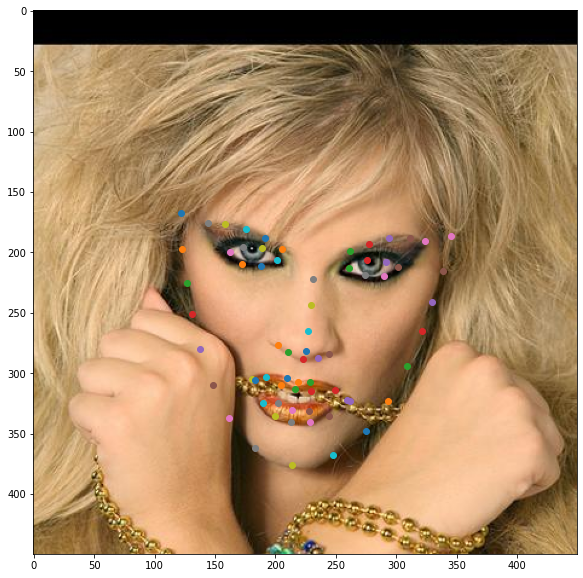

In [9]:
import cv2

plt.figure(figsize=(10,10))

img = cv2.imread('AFLW2000/image00002.jpg')
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in pts:
    plt.scatter(pt[0],pt[1]);

plt.imshow(plt_img);


In [10]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [11]:
get_ypr_from_mat(os.path.join('AFLW2000/',mylist[0]))

array([-0.39923078,  0.01822658,  0.08567622], dtype=float32)

In [12]:
from math import cos, sin

def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    
    
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    

    return img

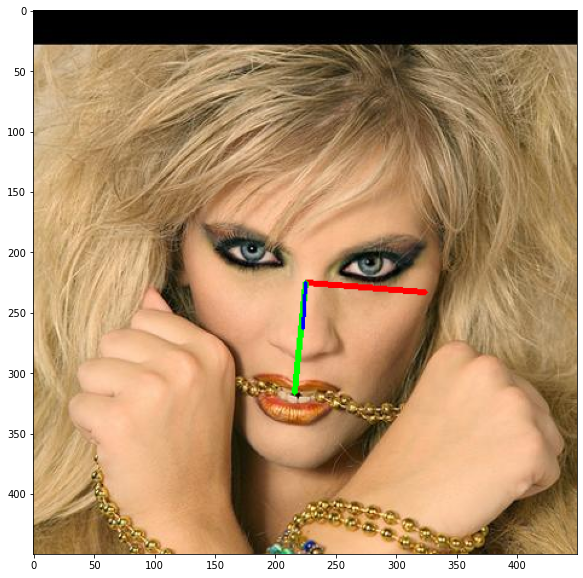

In [13]:
plt.figure(figsize=(10,10))

fnl_img = draw_axis(img, -0.39923078, 0.01822658, 0.08567622)
plt_fnl_img = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)

plt.imshow(plt_fnl_img)

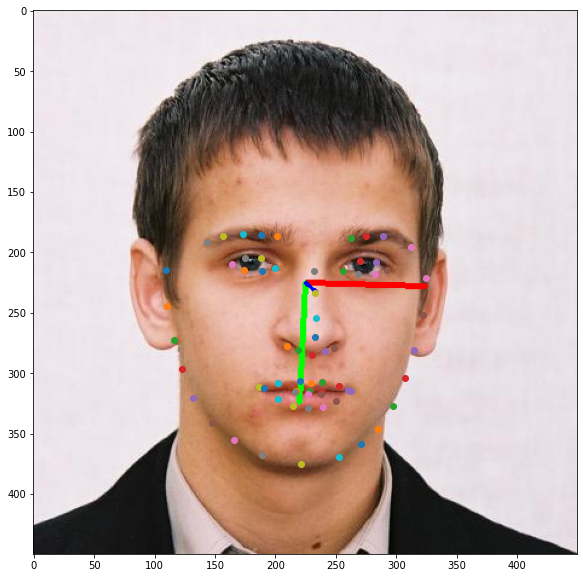

In [14]:
mat = sio.loadmat('AFLW2000/image00053.mat')
pt3d=mat['pt3d_68']
ypr = mat['Pose_Para']


plt.figure(figsize=(10,10))

img = cv2.imread('AFLW2000/image00053.jpg')

fnl_img = draw_axis(img, ypr[0,0], ypr[0,1], ypr[0,2])
plt_fnl_img = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)

pts = [x for x in zip(*get_pt2d_68_from_mat(os.path.join('AFLW2000/','image00053')))]

for pt in pts:
    plt.scatter(pt[0],pt[1]);

#plt.scatter(pts[30][0], pts[30][1])



plt.imshow(plt_fnl_img);

# Prepare Data

In [15]:
data_path = "AFLW2000/*.mat"
matlab_files =  get_list_from_filenames(data_path)

In [16]:
x_column_names = ['x'+str(i) for i in range(1, 69)]
y_column_names = ['y'+str(i) for i in range(1, 69)]
ypr_column_names = ['pitch', 'yaw', 'roll']

df = pd.DataFrame(columns=[x_column_names + y_column_names + ypr_column_names])

for index, matlab_file in enumerate(matlab_files):
    full_path = os.path.join('AFLW2000/', matlab_file)
    xs = get_pt2d_68_from_mat(full_path)[0]
    ys = get_pt2d_68_from_mat(full_path)[1]
    
    #print('X1 before: ', xs[0])
    #print("Noses X: ", xs[30])
    
    # Making points relative to nose
    xs = xs - xs[30]
    ys = ys - ys[30]
    
    #print('X1 after: ', xs[0])
    
    
    pyr = get_ypr_from_mat(full_path)
    
    df = df.append(
        pd.DataFrame(
            np.append(xs, np.append(ys, pyr ,axis=0),axis=0).reshape(1,-1),
            columns=df.columns),
        ignore_index=True)   
    

In [17]:
print(df.shape)

display(df.head(2))

(2000, 139)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y62,y63,y64,y65,y66,y67,y68,pitch,yaw,roll
0,-103.22039,-102.720818,-98.269188,-94.256638,-87.565292,-76.566696,-63.56041,-42.211746,-11.148361,22.916946,...,28.345642,31.43045,33.303711,40.581207,49.16217,48.89856,43.100464,-0.399231,0.018227,0.085676
1,95.086197,91.187454,88.724991,83.371811,71.636307,54.816193,35.649521,19.694336,20.933487,40.033676,...,40.735809,38.366455,37.702972,40.902893,37.127167,38.240601,39.928497,0.470065,1.189533,0.300959


# Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

x = df.drop(['pitch', 'yaw', 'roll'], axis=1)

pitch = df['pitch']
yaw = df['yaw']
roll = df['roll']

pitch_X_train, pitch_X_test, pitch_y_train, pitch_y_test = train_test_split(x, pitch, test_size=0.2,
                                                                    random_state=42)

yaw_X_train, yaw_X_test, yaw_y_train, yaw_y_test = train_test_split(x, yaw, test_size=0.2,
                                                                    random_state=42)

roll_X_train, roll_X_test, roll_y_train, roll_y_test = train_test_split(x, roll, test_size=0.2,
                                                                    random_state=42)

# Standard Scaling


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pitch_xtrain_scaled = scaler.fit_transform(pitch_X_train)
pitch_xtest_scaled = scaler.transform(pitch_X_test)

yaw_xtrain_scaled = scaler.fit_transform(yaw_X_train)
yaw_xtest_scaled = scaler.transform(yaw_X_test)

roll_xtrain_scaled = scaler.fit_transform(roll_X_train)
roll_xtest_scaled = scaler.transform(roll_X_test)

# Model Training

In [20]:
# models Used

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error as MSE


## Pitch Predictor

In [21]:
pitch_predictor = SVR(degree=3)

pitch_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

SVR()

In [22]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)



Training Scores
R2-Score:  -1.0792350868539389
RMSE : 0.8510406285654355

Testing Scores
R2-Score:  -0.7319542718780303
RMSE : 0.9993151236517948


## Yaw Predictor

In [23]:
yaw_predictor = SVR(degree=2)

yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

SVR(degree=2)

In [24]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9849932270494064
RMSE : 0.07820561361666918

Testing Scores
R2-Score:  0.7852496485485727
RMSE : 0.33036284847858244


## Roll Predictor

In [25]:
roll_predictor = RandomForestRegressor(n_estimators=20,
                                       criterion='squared_error',
                                       max_depth=8)

roll_predictor.fit(roll_xtrain_scaled, roll_y_train, )

RandomForestRegressor(max_depth=8, n_estimators=20)

In [26]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.8564291739840658
MSE : 0.23966835730290606

Testing Scores
R2-Score:  0.6835065863515436
MSE : 0.5509916493527093


## Testing Models on a photo

#### using dlib to extract faetures

In [27]:
#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [28]:
#!bzip2 -d  'shape_predictor_68_face_landmarks.dat.bz2'

In [29]:
import dlib
 
predictor=dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()


In [30]:
def convert_and_trim_bb(image, rect):
    # extract the starting and ending (x, y)-coordinates of the
    # bounding box
    startX = rect.left()
    startY = rect.top()
    endX = rect.right()
    endY = rect.bottom()

    # compute the width and height of the bounding box
    w = endX - startX
    h = endY - startY
    # return our bounding box coordinates
    return (startX, startY, w, h)

In [31]:
def resize_pad(im, size):
    #im = cv2.imread(im_path)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im

#     cv2.imshow('test_photo',new_im)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [32]:
# desired_size = 450
# im_pth = "photo.jpeg"

# resize_pad(im_pth, desired_size)

In [33]:
# def renderFace2(im, landmarks, color=(0, 255, 0), radius=3):
#     for p in landmarks.parts():
#          print(p)
#          cv2.circle(im, (p.x, p.y), radius, color, -1)

#          break

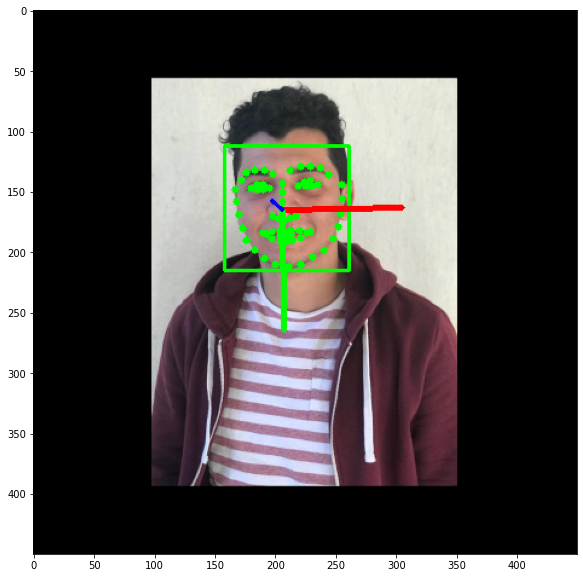

In [34]:
image_path="photo.jpeg"

desired_size = 450

im = cv2.imread(image_path)

frame = resize_pad(im, desired_size)

dets = cnn_face_detector(frame, 0)
for det in dets:
    # loop over all faces detected

    startX, startY, w, h = convert_and_trim_bb(frame, det)
    # Draw Rectangle
    cv2.rectangle(frame, (startX, startY), (startX + w, startY + h), (0, 255, 0), 2)

    shape = predictor(frame, det)

    tdx,tdy=shape.part(30).x, shape.part(30).y
    bbox_height, bbox_width = frame.shape[:2]


    xs = []
    ys = [] 

    for pt in shape.parts():  
        xs.append(pt.x)
        ys.append(pt.y)
        cv2.circle(frame, (pt.x, pt.y),
                  radius = 3, color=(0, 255, 0), thickness = -1)
        
    xs = np.array(xs) - tdx
    ys = np.array(ys) - tdy
        
    sample= np.append(xs, ys)
    sample = np.array(sample).reshape(1,-1)
    sample = scaler.transform(sample)
    pitch_prediction = pitch_predictor.predict(sample)
    yaw_prediction = yaw_predictor.predict(sample)
    roll_prediction = roll_predictor.predict(sample)

    draw_axis(frame, pitch_prediction,yaw_prediction, roll_prediction, tdx, tdy)

    plt.figure(figsize=(10,10))

    cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.imshow(cv2_frame)

In [35]:
def predict_draw_pyr(cv_frame):
    
    frame = resize_pad(cv_frame, 450)

    dets = cnn_face_detector(frame, 0)
    for det in dets:
        # Get x_min, y_min, x_max, y_max, conf

        startX, startY, w, h = convert_and_trim_bb(frame, det)
        cv2.rectangle(frame, (startX, startY), (startX + w, startY + h), (0, 255, 0), 2)

        shape = predictor(frame, det)
        tdx,tdy=shape.part(30).x, shape.part(30).y
        bbox_height, bbox_width = frame.shape[:2]

        xs = []
        ys = [] 

        for pt in shape.parts():  
            xs.append(pt.x)
            ys.append(pt.y)
            cv2.circle(frame, (pt.x, pt.y),
                    radius = 3, color=(0, 255, 0), thickness = -1)
          
        xs = np.array(xs) - tdx
        ys = np.array(ys) - tdy

        sample= np.append(xs, ys)
        sample = np.array(sample).reshape(1,-1)
        sample = scaler.transform(sample)
        pitch_prediction = pitch_predictor.predict(sample)
        yaw_prediction = yaw_predictor.predict(sample)
        roll_prediction = roll_predictor.predict(sample)

        frame = draw_axis(frame, pitch_prediction,yaw_prediction, roll_prediction, tdx, tdy)
        return frame

# Testing on my face

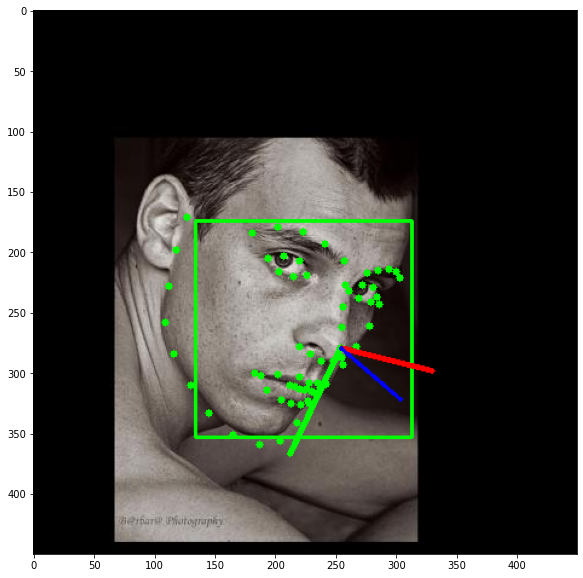

In [36]:
im_pth = 'AFLW2000/image00035.jpg'
frame = cv2.imread(im_pth)
frame = predict_draw_pyr(frame)

plt.figure(figsize=(10,10))

cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(cv2_frame)


In [39]:
video_path = "C:/Users/DELL/AppData/Roaming/SPB_Data/[ITI]/Machine Learning 1/HeadPose Estimatio/test.mp4"

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, cv_frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    #cv_frame = cv2.cvtColor(cv_frame, cv2.COLOR_BGR2RGB)
    try:
        cv_frame = predict_draw_pyr(cv_frame)   
        imS = cv2.resize(cv_frame, (450, 450)) 
        cv2.imshow('yalla bean-a', imS)
        cv2.waitKey(1)
    except:
        continue
        
    finally:
        pass

        
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
